In [1]:
!pip install torchinfo
!pip install torchmetrics

In [2]:
import pandas as pd
import joblib
from functools import partial
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter
from torchtext.vocab import vocab
import torch
from torchinfo import summary
from torchmetrics import HammingDistance

In [3]:
df = joblib.load('/content/drive/MyDrive/df_multilabel_hw_cleaned.joblib')
df.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [4]:
df['Tag_Number_int'] = df['Tag_Number'].apply(ast.literal_eval)
df.head()

,cleaned_text,Tags,Tag_Number,Tag_Number_int
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]","[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]","[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]","[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]","[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]","[3, 5]"


In [5]:
mlb = MultiLabelBinarizer()
one_hot_encoded_tags = mlb.fit_transform(df['Tag_Number_int']).astype(float)
print("Classes:", mlb.classes_)

Classes: [0 1 2 3 4 5 6 7 8 9]


In [6]:
one_hot_encoded_tags

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(df['cleaned_text'].values, one_hot_encoded_tags, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((28455,), (9486,), (9486,))

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        texts = self.X[idx]
        labels = self.y[idx]
        sample = (labels, texts)

        return sample

In [10]:
trainset = CustomDataset(X_train, y_train)
validset = CustomDataset(X_val, y_val)
testset = CustomDataset(X_test, y_test)

In [11]:
def get_vocab(dataset, min_freq=1):
    counter = Counter()
    for (label, text) in dataset:
        counter.update(text.split())
    my_vocab = vocab(counter, min_freq=min_freq)
    my_vocab.insert_token('<unk>', 0)
    my_vocab.set_default_index(0)

    return my_vocab

In [12]:
train_vocab = get_vocab(trainset, min_freq=2)

In [13]:
def tokenizer(x, vocab):
    return [vocab[token] for token in x.split()]

In [14]:
def collate_batch(batch, my_vocab):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.long)
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]
    indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return (indices, offsets), labels

In [15]:
collate_partial = partial(collate_batch, my_vocab=train_vocab)
check_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=2,
                                           shuffle=True, collate_fn=collate_partial)

In [16]:
for (indices, offset), label in check_loader:
    print(indices, offset, label)
    break

tensor([   98, 13383,   173,   985,    70,   488,   199,     0,  2224,    97,
           98,   241,   227,   252,   101,     0,  2224,  3225,    18,  3225,
          816,    18,     0,   407,     0,     5,   989, 27651,   696,  2825,
          309,  1241,   226,   987,   343,  1758,    17,  1086,  1821,   103,
          411,  1241,   681,    39,   197,  4471,   568,   293,  4015,  1040,
          568,  6197,  1437,    70,  2412,   985,   496,   653,   197,  1672,
          132,  2412,   252,  2025,   647,   567,   201,   907,   527,   528,
         4015,   568,   370,   723,  1355,   560,   568,  4294,   629,   567,
          342,   567,   619,   668,   560,    41,   641,   942,   943,   944,
         1781,   261,     0,    48,   261,     0,  1781,   919,   919,    48,
        60950,  1781,  2025, 68819,    48,  2025,     0,  1781,  2025,     0,
           48,  2025,     0,  1781,    64, 68820,    48,  1967,  4941,  3186,
         1781,    64, 68821,    48,  1967,  4941,  4943,  1781, 

<ipython-input-14-b523db7c5814>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.long)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim, mode='mean')
        self.fc1 = nn.Linear(embedding_dim, hidden_dim1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(drop_prob1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(drop_prob2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, input_tuple):
        indices, offsets = input_tuple
        x = self.embedding_bag(indices, offsets)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        output = self.fc3(x)

        return output

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleMLP(vocab_size=10 , embedding_dim=300, hidden_dim1=200, hidden_dim2=100, drop_prob1=0.5, drop_prob2=0.5, num_outputs=10)
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)

summary(model, input_data=[(data, offsets)], device=device, depth=10, verbose=False)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleMLP                                [3, 10]                   --
├─EmbeddingBag: 1-1                      [3, 300]                  3,000
├─Linear: 1-2                            [3, 200]                  60,200
├─ReLU: 1-3                              [3, 200]                  --
├─Dropout: 1-4                           [3, 200]                  --
├─BatchNorm1d: 1-5                       [3, 200]                  400
├─Linear: 1-6                            [3, 100]                  20,100
├─ReLU: 1-7                              [3, 100]                  --
├─Dropout: 1-8                           [3, 100]                  --
├─BatchNorm1d: 1-9                       [3, 100]                  200
├─Linear: 1-10                           [3, 10]                   1,010
Total params: 84,910
Trainable params: 84,910
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.00
Forward/backward pass

In [20]:
output = model((data, offsets))
print(output)

tensor([[ 0.4241,  0.0916,  0.2717, -0.2661, -0.0904, -0.4252, -0.5955, -0.2791,
          0.6692,  0.5841],
        [-0.2563, -0.5006, -0.3026, -0.2827,  0.4733, -0.2126,  0.0840, -0.2129,
         -1.0135, -0.5543],
        [ 0.0122,  0.6028,  0.0529,  0.3907, -0.2295,  0.3974,  0.4681,  0.2645,
          0.0876, -0.0246]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [21]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    model = model.to(device)
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(dtype=torch.float32)
    targets = targets.to(device)

    outputs = model(inputs)

    if loss_function:
        loss = loss_function(outputs, targets)

    predicted = outputs.to(device)

    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
        optimizer.step()

    if loss_function:
        return loss, predicted
    else:
        return None, predicted

In [22]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model.train()
    running_train_loss = 0.0

    for inputs, targets in train_loader:
        targets = targets.to(device)
        loss, predicted = step(inputs, targets, model, device, loss_function, optimizer)
        running_train_loss += loss.item()
        train_hamming_distance.update(predicted, targets)

    train_loss = running_train_loss / len(train_loader)
    train_hamming_distance = train_hamming_distance.compute()

    return train_loss, train_hamming_distance

In [23]:
def val_epoch(valid_loader, model, device, loss_function):
    val_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model.train()
    running_val_loss = 0.0

    for inputs, targets in valid_loader:
        targets = targets.to(device)
        loss, predicted = step(inputs, targets, model, device, loss_function, optimizer=None)
        running_val_loss += loss.item()
        val_hamming_distance.update(predicted, targets)

    val_loss = running_val_loss / len(valid_loader)
    val_hamming_distance = val_hamming_distance.compute()

    return val_loss, val_hamming_distance

In [24]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience):
    train_loss_history = []
    valid_loss_history = []
    train_hamm_history = []
    valid_hamm_history = []

    for epoch in range(epochs):
        train_loss, train_hamm = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        valid_loss, valid_hamm = val_epoch(
            valid_loader, model, device, loss_function)

        train_loss_history.append(train_loss)
        train_hamm_history.append(train_hamm)
        valid_loss_history.append(valid_loss)
        valid_hamm_history.append(valid_hamm)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Loss: {train_hamm}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Hamming Loss: {valid_hamm}")
        print()

        if all(element == valid_loss_history[-1] for element in valid_loss_history[-patience:]):
          break

    return train_loss_history, train_hamm_history, valid_loss_history, valid_hamm_history

In [25]:
# model Parameters
EMBED_DIM=300
VOCAB_SIZE=len(train_vocab)
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=10
PATIENCE=5

# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.0

In [26]:
import random
import numpy as np

SEED = 1103
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

collate_fn = partial(collate_batch, my_vocab=train_vocab)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn, num_workers=4)

loss_function = nn.BCEWithLogitsLoss()

model_facebook = SimpleMLP(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBED_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS)

optimizer = torch.optim.AdamW(model_facebook.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [27]:
for inputs, targets in train_loader:
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(dtype=torch.float32, copy=False).to(device)
    model_facebook = model_facebook.to(device)
    model_facebook.eval()

    with torch.no_grad():
        output = model_facebook(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Actual loss: 0.6975612044334412
Expected Theoretical loss: 0.6931471805599453


In [28]:
%%time
train_losses, train_hamm, valid_losses, valid_hamm = train(
    train_loader, valid_loader, model_facebook, optimizer, loss_function, EPOCHS, device, PATIENCE)

Epoch 1/5
Train Loss: 0.3963 | Train Hamming Loss: 0.17122822999954224
Valid Loss: 0.2056 | Valid Hamming Loss: 0.07180052995681763

Epoch 2/5
Train Loss: 0.1678 | Train Hamming Loss: 0.05844312906265259
Valid Loss: 0.1660 | Valid Hamming Loss: 0.060046374797821045

Epoch 3/5
Train Loss: 0.1351 | Train Hamming Loss: 0.04784047603607178
Valid Loss: 0.1549 | Valid Hamming Loss: 0.055703163146972656

Epoch 4/5
Train Loss: 0.1168 | Train Hamming Loss: 0.04193991422653198
Valid Loss: 0.1454 | Valid Hamming Loss: 0.050748467445373535

Epoch 5/5
Train Loss: 0.1029 | Train Hamming Loss: 0.03718852996826172
Valid Loss: 0.1406 | Valid Hamming Loss: 0.04868227243423462

CPU times: user 18.9 s, sys: 1.66 s, total: 20.5 s
Wall time: 29.6 s


In [29]:
import matplotlib.pyplot as plt
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")
    if val_losses:
        plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    if train_metrics[0] is not None:
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")
        if val_metrics:
            plt.plot(epochs, val_metrics, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Metric (Hamming loss)")
        plt.legend()
        plt.show()

In [30]:
train_hamm[0].item()

0.17122822999954224

In [31]:
train_hamm = [i.item() for i in train_hamm]
valid_hamm = [i.item() for i in valid_hamm]

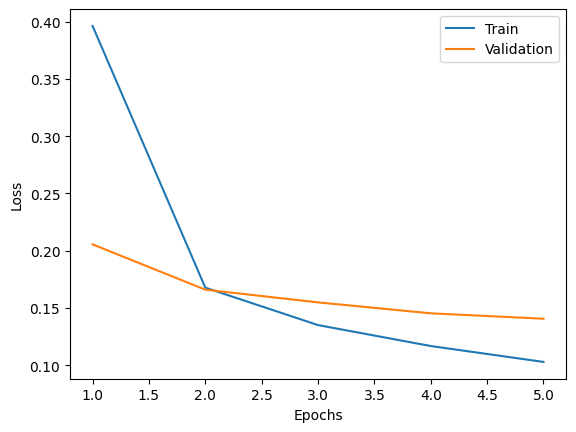

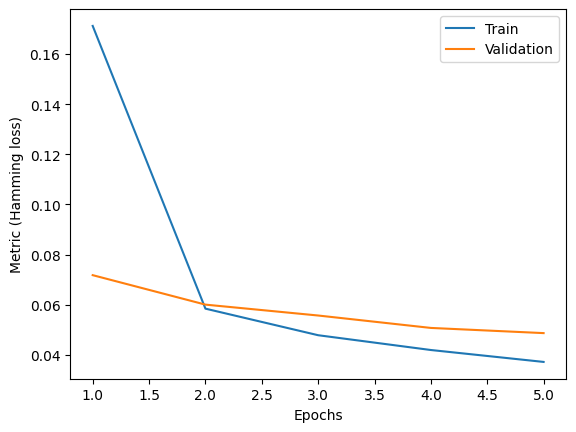

In [32]:
plot_history(train_losses, train_hamm, valid_losses, valid_hamm)

In [33]:
def get_acc_pred(data_loader, model, device):
    val_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model = model.to(device)
    model.eval()

    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    running_correct = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            targets = targets.to(device)
            _, predicted = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets))
            val_hamming_distance.update(predicted, targets)

    val_hamming_distance = val_hamming_distance.compute()

    return predictions, y, val_hamming_distance.item()

In [34]:
predictions_test, labels_test, hamming_distance_test = get_acc_pred(test_loader, model_facebook, device)
predictions_train, labels_train, hamming_distance_train = get_acc_pred(train_loader, model_facebook, device)
predictions_val, labels_val, hamming_distance_val = get_acc_pred(valid_loader, model_facebook, device)

In [35]:
# Print Test Accuracy
print('Test hamming distance:', hamming_distance_test)

Test hamming distance: 0.04128187894821167


In [37]:
hamming_distance_train, hamming_distance_val, hamming_distance_test

(0.025605320930480957, 0.04106050729751587, 0.04128187894821167)

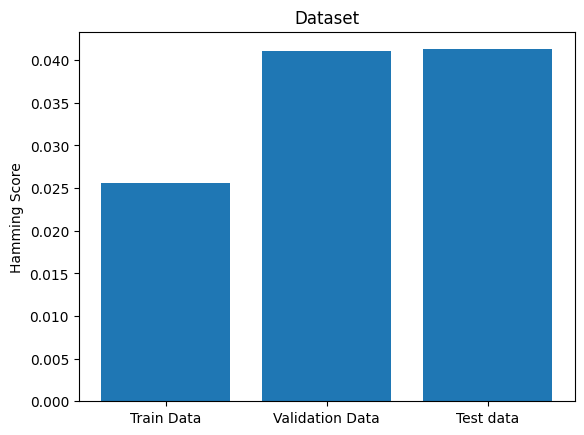

In [36]:
import matplotlib.pyplot as plt

# Scalar values
values = [hamming_distance_train, hamming_distance_val, hamming_distance_test]
labels = ['Train Data', 'Validation Data', 'Test data']

# Plotting
plt.bar(labels, values)
plt.ylabel('Hamming Score')
plt.title('Dataset')
plt.show()

The model demonstrates good generalization capabilities, as evidenced by the minimal increase in Hamming distance when moving from the training set to the validation and test sets. This minor uptick is typical when models encounter new data, indicating that the model is not overly fitted to the training data and retains its predictive accuracy on unseen data.

The similarity in Hamming distances between the validation and test sets underscores the model's consistent performance across various unseen data sets. This consistency underscores the model’s dependability and stability.

Considering the low Hamming distances observed across the board, it's evident that the model achieves a high level of accuracy in its predictions for this multi-label classification task, with incorrect predictions being as low as approximately 0.025 for the training set and around 0.041 and 0.041 for the validation and test sets respectively.